PAN-Level Anomaly Detectionng

PROJECT GOAL:
Build ML model to detect anomalous PANs (not individual transactions).
Output matches current rule-based system: Flag PANs with suspicious patterns.
Alerts sent to issuer banks for investigation.

# 1. IMPORTS AND SETUP

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import gc

# 2. DATA LOADING - TRANSACTIONS

In [5]:
# Common columns in both POS and ATM
common_columns = [
    'PAN', 'PERIOD', 'TIME', 'AMOUNT', 'TRAN_TYPE', 'POS_ENTRY_MODE',
    'TERM_ID', 'TERM_OWNER_NAME', 'STATUS', 'RTCODE', 'MSG_TYPE',
    'ACQ_ID', 'ISS_ID'
]

## 2.1 Load POS Data

In [6]:
df_pos = pd.read_csv(
    '/kaggle/input/rintis/raw.csv',
    usecols=common_columns,
    dtype={
        'PAN': 'category',
        'PERIOD': str,
        'TIME': str,
        'AMOUNT': 'float32',
        'TRAN_TYPE': 'category',
        'POS_ENTRY_MODE': 'category',
        'TERM_ID': 'category',
        'TERM_OWNER_NAME': 'category',
        'STATUS': str,
        'RTCODE': 'category',
        'MSG_TYPE': 'category',
        'ACQ_ID': 'category',
        'ISS_ID': 'category'
    },
    na_values=['', ' ', 'nan', 'NaN', 'NULL']
)

df_pos['SOURCE'] = 'POS'

## 2.2 Load ATM Data

In [7]:
df_atm = pd.read_csv(
    '/kaggle/input/rintis/export.csv',
    usecols=common_columns,
    dtype={
        'PAN': 'category',
        'PERIOD': str,
        'TIME': str,
        'AMOUNT': 'float32',
        'TRAN_TYPE': 'category',
        'POS_ENTRY_MODE': 'category',
        'TERM_ID': 'category',
        'TERM_OWNER_NAME': 'category',
        'STATUS': str,
        'RTCODE': 'category',
        'MSG_TYPE': 'category',
        'ACQ_ID': 'category',
        'ISS_ID': 'category'
    },
    na_values=['', ' ', 'nan', 'NaN', 'NULL']
)
df_atm['SOURCE'] = 'ATM'

## 2.3 Combine Datasets

In [8]:
df_combined = pd.concat([df_pos, df_atm], ignore_index=True)
del df_pos, df_atm
gc.collect()

print(f"Total transactions: {len(df_combined):,}")
print(f"Memory usage: {df_combined.memory_usage(deep=True).sum() / 1024**3:.2f} GB")

Total transactions: 41,507,829
Memory usage: 31.33 GB


# 3. DATA CLEANING

## 3.1 Clean STATUS Column

In [9]:
df_combined['STATUS'] = df_combined['STATUS'].fillna('UNKNOWN')
df_combined['STATUS'] = df_combined['STATUS'].str.strip()
df_combined['STATUS'] = df_combined['STATUS'].replace('', 'UNKNOWN')
df_combined['STATUS'] = df_combined['STATUS'].astype('category')
df_combined['SOURCE'] = df_combined['SOURCE'].astype('category')

# 4. DATETIME PARSING

## 4.1 Create datetime string

In [10]:
df_combined['PERIOD_STR'] = df_combined['PERIOD'].astype(str).str.zfill(6)
df_combined['TIME_STR'] = df_combined['TIME'].astype(str).str.zfill(6)
df_combined['DATETIME_STR'] = df_combined['PERIOD_STR'] + df_combined['TIME_STR']

## 4.2 Parse datetime

In [11]:
df_combined['DATETIME'] = pd.to_datetime(
    df_combined['DATETIME_STR'],
    format='%y%m%d%H%M%S',
    errors='coerce'
)

df_combined = df_combined.drop(['PERIOD_STR', 'TIME_STR', 'DATETIME_STR'], axis=1)

In [12]:
df_combined['DATETIME'].head(3)

0   2025-06-18 10:05:14
1   2025-06-18 10:05:14
2   2025-06-18 10:05:14
Name: DATETIME, dtype: datetime64[ns]

## 4.3 Handled failed parses

In [13]:
failed_datetime = df_combined['DATETIME'].isna().sum()
print(f"Failed to parse DATETIME: {failed_datetime} rows ({failed_datetime/len(df_combined)*100:.2f}%)")

if failed_datetime > 0:
    df_combined = df_combined[df_combined['DATETIME'].notna()].copy()
    df_combined = df_combined.reset_index(drop=True)

Failed to parse DATETIME: 648 rows (0.00%)


## 4.4 Sort by datetime

In [14]:
df_combined = df_combined.sort_values('DATETIME').reset_index(drop=True)

print(f"Date range: {df_combined['DATETIME'].min()} to {df_combined['DATETIME'].max()}")
print(f"Final transaction count: {len(df_combined):,}")

Date range: 2022-12-08 21:42:26 to 2025-09-19 17:25:25
Final transaction count: 41,507,181


# 5. STRATIFIED UNDERSAMPLING

In [15]:
# Target: 10M transactions
TARGET_SIZE = 10_000_000

if len(df_combined) > TARGET_SIZE:
    print(f"\nReducing to {TARGET_SIZE:,} transactions...")
    
    # Strategy: Keep all transactions from PANs that will be in fraud table
    # This ensures we don't lose anomalous PANs
    
    ## 5.1: Load fraud table first (to identify important PANs)
    print("\nStep 1: Loading fraud flags to identify important PANs...")
    
    fraud_cols = ["PAN","TRX_TYPE"]
    
    fraud_df = pd.read_csv(
        "/kaggle/input/rintis/fraud.csv", 
        usecols=fraud_cols,
        dtype={'PAN': str},
        on_bad_lines='skip'
    )
    
    fraud_df['PAN'] = fraud_df['PAN'].astype(str).str.strip()
    fraud_df_filtered = fraud_df[fraud_df['TRX_TYPE'] != 'PGW'].copy()
    anomalous_pans = set(fraud_df_filtered['PAN'].unique())
    
    print(f"   Found {len(anomalous_pans):,} anomalous PANs")
    
    ## 5.2: Separate anomalous and normal transactions
    print("\nStep 2: Separating anomalous and normal transactions...")
    
    df_combined['PAN_STR'] = df_combined['PAN'].astype(str)
    is_anomalous = df_combined['PAN_STR'].isin(anomalous_pans)
    
    anomalous_txns = df_combined[is_anomalous].copy()
    normal_txns = df_combined[~is_anomalous].copy()
    
    print(f"   Anomalous transactions: {len(anomalous_txns):,}")
    print(f"   Normal transactions: {len(normal_txns):,}")
    
    ## 5.3: Keep ALL anomalous transactions
    print("\nStep 3: Keeping all anomalous transactions...")
    keep_anomalous = anomalous_txns
    print(f"   Kept: {len(keep_anomalous):,} anomalous transactions")
    
    ## 5.4: Sample normal transactions
    remaining_budget = TARGET_SIZE - len(keep_anomalous)
    
    if remaining_budget > 0 and len(normal_txns) > remaining_budget:
        print(f"\nStep 4: Sampling {remaining_budget:,} normal transactions...")
        
        # Stratified by SOURCE and STATUS
        sample_normal = normal_txns.groupby(['SOURCE', 'STATUS'], group_keys=False).apply(
            lambda x: x.sample(
                min(len(x), int(remaining_budget * len(x) / len(normal_txns))),
                random_state=42
            )
        ).reset_index(drop=True)
        
        print(f"   Sampled: {len(sample_normal):,} normal transactions")
    else:
        sample_normal = normal_txns
        print(f"\nStep 4: Keeping all {len(sample_normal):,} normal transactions")
    
    ## 5.5: Recombine
    print("\nStep 5: Recombining dataset...")
    df_combined = pd.concat([keep_anomalous, sample_normal], ignore_index=True)
    df_combined = df_combined.sort_values('DATETIME').reset_index(drop=True)
    
    # Clean up
    del anomalous_txns, normal_txns, keep_anomalous, sample_normal
    gc.collect()
    
    print(f"\n✓ Undersampling complete!")
    print(f"  Final size: {len(df_combined):,} transactions")
    print(f"  Memory usage: {df_combined.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
    
    # Show new distribution
    is_anomalous_final = df_combined['PAN_STR'].isin(anomalous_pans)
    print(f"\n  Anomalous transactions: {is_anomalous_final.sum():,} ({is_anomalous_final.sum()/len(df_combined)*100:.2f}%)")
    print(f"  Normal transactions: {(~is_anomalous_final).sum():,} ({(~is_anomalous_final).sum()/len(df_combined)*100:.2f}%)")
    
    # Drop temporary column
    df_combined = df_combined.drop('PAN_STR', axis=1)
    
else:
    print(f"\nDataset already under {TARGET_SIZE:,} transactions ✓")
    
    # Still need to load fraud table for later
    fraud_cols = ["PAN","TRX_TYPE"]
    
    fraud_df = pd.read_csv(
        "/kaggle/input/rintis/fraud.csv", 
        usecols=fraud_cols,
        dtype={'PAN': str},
        on_bad_lines='skip'
    )
    
    fraud_df['PAN'] = fraud_df['PAN'].astype(str).str.strip()
    fraud_df_filtered = fraud_df[fraud_df['TRX_TYPE'] != 'PGW'].copy()
    anomalous_pans = set(fraud_df_filtered['PAN'].unique())


Reducing to 10,000,000 transactions...

Step 1: Loading fraud flags to identify important PANs...
   Found 2,149,006 anomalous PANs

Step 2: Separating anomalous and normal transactions...
   Anomalous transactions: 5,716,595
   Normal transactions: 35,790,586

Step 3: Keeping all anomalous transactions...
   Kept: 5,716,595 anomalous transactions

Step 4: Sampling 4,283,405 normal transactions...


/tmp/ipykernel_37/2285082813.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_normal = normal_txns.groupby(['SOURCE', 'STATUS'], group_keys=False).apply(
/tmp/ipykernel_37/2285082813.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_normal = normal_txns.groupby(['SOURCE', 'STATUS'], group_keys=False).apply(


   Sampled: 4,283,398 normal transactions

Step 5: Recombining dataset...

✓ Undersampling complete!
  Final size: 9,999,993 transactions
  Memory usage: 7.40 GB

  Anomalous transactions: 5,716,595 (57.17%)
  Normal transactions: 4,283,398 (42.83%)


# 6. TRANSACTION-LEVEL FEATURE ENGINEERING

## 6.1 Temporal Features

In [16]:
df_combined['HOUR'] = df_combined['DATETIME'].dt.hour
df_combined['DAY_OF_WEEK'] = df_combined['DATETIME'].dt.dayofweek
df_combined['DAY_OF_MONTH'] = df_combined['DATETIME'].dt.day
df_combined['MONTH'] = df_combined['DATETIME'].dt.month
df_combined['IS_WEEKEND'] = (df_combined['DAY_OF_WEEK'] >= 5).astype(int)
df_combined['IS_NIGHT'] = ((df_combined['HOUR'] >= 0) & (df_combined['HOUR'] < 6)).astype(int)

## 6.2 Categorical Encoding

In [17]:
# Convert categoricals to string for encoding
df_combined['RTCODE_STR'] = df_combined['RTCODE'].astype(str)
df_combined['MSG_TYPE_STR'] = df_combined['MSG_TYPE'].astype(str)
df_combined['SOURCE_STR'] = df_combined['SOURCE'].astype(str)

# Transaction type indicators (from rule-based system logic)
df_combined['IS_APPROVED'] = df_combined['RTCODE_STR'].isin(['7000', '7001']).astype(int)
df_combined['IS_DECLINED_FEE'] = df_combined['RTCODE_STR'].isin(['7059', '7058', '7053', '7051']).astype(int)
df_combined['IS_DECLINED_FREE'] = (~df_combined['RTCODE_STR'].isin(['7000', '7001', '7059', '7058', '7053', '7051'])).astype(int)
df_combined['IS_REVERSAL'] = (df_combined['MSG_TYPE_STR'] == '0420').astype(int)

# 7. AGGREGATE TO PAN-LEVEL FEATURES

## 7.1 Basic Aggregations

In [18]:
pan_features = df_combined.groupby('PAN').agg({
    'AMOUNT': [
        ('TXN_COUNT', 'count'),
        ('TOTAL_AMOUNT', 'sum'),
        ('AVG_AMOUNT', 'mean'),
        ('STD_AMOUNT', 'std'),
        ('MAX_AMOUNT', 'max'),
        ('MIN_AMOUNT', 'min')
    ],
    'DATETIME': [
        ('FIRST_TXN_DATE', 'min'),
        ('LAST_TXN_DATE', 'max')
    ]
}).reset_index()

In [19]:
# Flatten column names
pan_features.columns = ['PAN'] + [col[1] if col[1] else col[0] for col in pan_features.columns[1:]]

# Calculate date span
pan_features['DATE_SPAN_DAYS'] = (
    pd.to_datetime(pan_features['LAST_TXN_DATE']) - 
    pd.to_datetime(pan_features['FIRST_TXN_DATE'])
).dt.days

In [20]:
print(f"   Created PAN dataset: {len(pan_features):,} unique PANs")

   Created PAN dataset: 3,558,812 unique PANs


## 7.2 Time-based features

In [21]:
time_features = df_combined.groupby('PAN').agg({
    'IS_NIGHT': [('NIGHT_TXN_COUNT', 'sum')],
    'IS_WEEKEND': [('WEEKEND_TXN_COUNT', 'sum')],
    'HOUR': [('AVG_HOUR', 'mean')]
}).reset_index()
time_features.columns = ['PAN'] + [col[1] for col in time_features.columns[1:]]

pan_features = pan_features.merge(time_features, on='PAN', how='left')

## 7.3 Transaction type features

In [22]:
type_features = df_combined.groupby('PAN').agg({
    'IS_APPROVED': [('APPROVED_COUNT', 'sum')],
    'IS_DECLINED_FEE': [('DECLINED_FEE_COUNT', 'sum')],
    'IS_DECLINED_FREE': [('DECLINED_FREE_COUNT', 'sum')],
    'IS_REVERSAL': [('REVERSAL_COUNT', 'sum')]
}).reset_index()
type_features.columns = ['PAN'] + [col[1] for col in type_features.columns[1:]]

pan_features = pan_features.merge(type_features, on='PAN', how='left')

## 7.4 Source and diversity features

In [23]:
diversity_features = df_combined.groupby('PAN').agg({
    'SOURCE_STR': [('UNIQUE_SOURCES', 'nunique')],
    'TRAN_TYPE': [('UNIQUE_TRAN_TYPES', 'nunique')],
    'TERM_ID': [('UNIQUE_TERMINALS', 'nunique')]
}).reset_index()
diversity_features.columns = ['PAN'] + [col[1] for col in diversity_features.columns[1:]]

pan_features = pan_features.merge(diversity_features, on='PAN', how='left')

## 7.5 Velocity features

In [24]:
# Calculate time between transactions
df_sorted = df_combined.sort_values(['PAN', 'DATETIME']).copy()
df_sorted['TIME_DIFF_HOURS'] = df_sorted.groupby('PAN')['DATETIME'].diff().dt.total_seconds() / 3600

velocity_features = df_sorted.groupby('PAN')['TIME_DIFF_HOURS'].agg([
    ('AVG_TIME_BETWEEN_TXN', 'mean'),
    ('MIN_TIME_BETWEEN_TXN', 'min'),
    ('RAPID_TXN_COUNT', lambda x: (x < 1).sum())  # Txns within 1 hour
]).reset_index()

pan_features = pan_features.merge(velocity_features, on='PAN', how='left')

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


## 7.6 Daily maximum features

In [25]:
df_combined['DATE'] = df_combined['DATETIME'].dt.date
daily_stats = df_combined.groupby(['PAN', 'DATE']).agg({
    'AMOUNT': ['count', 'sum']
}).reset_index()
daily_stats.columns = ['PAN', 'DATE', 'DAILY_TXN_COUNT', 'DAILY_AMOUNT']

max_daily = daily_stats.groupby('PAN').agg({
    'DAILY_TXN_COUNT': 'max',
    'DAILY_AMOUNT': 'max'
}).reset_index()
max_daily.columns = ['PAN', 'MAX_TXN_PER_DAY', 'MAX_AMOUNT_PER_DAY']

pan_features = pan_features.merge(max_daily, on='PAN', how='left')

## 7.7 Calculate ratios

In [26]:
pan_features['NIGHT_TXN_RATIO'] = pan_features['NIGHT_TXN_COUNT'] / pan_features['TXN_COUNT']
pan_features['WEEKEND_TXN_RATIO'] = pan_features['WEEKEND_TXN_COUNT'] / pan_features['TXN_COUNT']
pan_features['APPROVED_RATIO'] = pan_features['APPROVED_COUNT'] / pan_features['TXN_COUNT']
pan_features['DECLINED_RATIO'] = (pan_features['DECLINED_FEE_COUNT'] + pan_features['DECLINED_FREE_COUNT']) / pan_features['TXN_COUNT']
pan_features['REVERSAL_RATIO'] = pan_features['REVERSAL_COUNT'] / pan_features['TXN_COUNT']
pan_features['TXN_PER_DAY'] = pan_features['TXN_COUNT'] / (pan_features['DATE_SPAN_DAYS'] + 1)

print(f"  Total PANs: {len(pan_features):,}")
print(f"  Total features: {len(pan_features.columns) - 1}")

  Total PANs: 3,558,812
  Total features: 30


In [27]:
issuer_acq_features = df_combined.groupby('PAN').agg({
    'ISS_ID': [
        ('PRIMARY_ISSUER', lambda x: x.mode()[0] if len(x.mode()) > 0 else 'UNKNOWN'),
        ('UNIQUE_ISSUERS', 'nunique')
    ],
    'ACQ_ID': [
        ('PRIMARY_ACQUIRER', lambda x: x.mode()[0] if len(x.mode()) > 0 else 'UNKNOWN'),
        ('UNIQUE_ACQUIRERS', 'nunique')
    ]
}).reset_index()

issuer_acq_features.columns = ['PAN', 'PRIMARY_ISSUER', 'UNIQUE_ISSUERS', 
                                'PRIMARY_ACQUIRER', 'UNIQUE_ACQUIRERS']

pan_features = pan_features.merge(issuer_acq_features, on='PAN', how='left')

In [28]:
# Encode issuers and acquirers
le_issuer = LabelEncoder()
le_acquirer = LabelEncoder()

pan_features['ISSUER_ENCODED'] = le_issuer.fit_transform(
    pan_features['PRIMARY_ISSUER'].astype(str)
)
pan_features['ACQUIRER_ENCODED'] = le_acquirer.fit_transform(
    pan_features['PRIMARY_ACQUIRER'].astype(str)
)

print(f"   Found {pan_features['PRIMARY_ISSUER'].nunique()} unique issuers")
print(f"   Found {pan_features['PRIMARY_ACQUIRER'].nunique()} unique acquirers")

   Found 105 unique issuers
   Found 101 unique acquirers


# 8. LABEL PANS AS NORMAL VS ANOMALOUS

In [29]:
# Label: 1 if PAN flagged by rule-based system, 0 otherwise
pan_features['LABEL'] = pan_features['PAN'].isin(anomalous_pans).astype(int)

label_counts = pan_features['LABEL'].value_counts()
print(f"\nPAN-level label distribution:")
print(f"  Normal PANs (0):     {label_counts[0]:,} ({label_counts[0]/len(pan_features)*100:.2f}%)")
print(f"  Anomalous PANs (1):  {label_counts[1]:,} ({label_counts[1]/len(pan_features)*100:.2f}%)")
print(f"\nClass imbalance ratio: 1:{label_counts[0]/label_counts[1]:.1f}")


PAN-level label distribution:
  Normal PANs (0):     3,359,149 (94.39%)
  Anomalous PANs (1):  199,663 (5.61%)

Class imbalance ratio: 1:16.8


# 9. HANDLE MISSING VALUES

In [30]:
# Check for missing values
missing_summary = pan_features.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

if len(missing_summary) > 0:
    print(f"Columns with missing values:")
    print(missing_summary)
    
    # Fill numeric columns with 0
    numeric_cols = pan_features.select_dtypes(include=[np.number]).columns
    pan_features[numeric_cols] = pan_features[numeric_cols].fillna(0)
    
    print(f"\n✓ Filled {len(numeric_cols)} numeric columns with 0")
else:
    print("No missing values found ✓")

# Replace inf values
pan_features = pan_features.replace([np.inf, -np.inf], 0)

Columns with missing values:
STD_AMOUNT              2995447
AVG_TIME_BETWEEN_TXN    2995447
MIN_TIME_BETWEEN_TXN    2995447
dtype: int64

✓ Filled 33 numeric columns with 0


# 10. FEATURE SELECTION

In [31]:
# Select features (exclude PAN, LABEL, and datetime columns)
exclude_cols = [
    'PAN', 'LABEL', 
    'FIRST_TXN_DATE', 'LAST_TXN_DATE',
    'PRIMARY_ISSUER', 'PRIMARY_ACQUIRER' 
]
feature_cols = [col for col in pan_features.columns if col not in exclude_cols]

print(f"Selected {len(feature_cols)} features for modeling")
print(f"\nFeatures: {feature_cols}")

Selected 32 features for modeling

Features: ['TXN_COUNT', 'TOTAL_AMOUNT', 'AVG_AMOUNT', 'STD_AMOUNT', 'MAX_AMOUNT', 'MIN_AMOUNT', 'DATE_SPAN_DAYS', 'NIGHT_TXN_COUNT', 'WEEKEND_TXN_COUNT', 'AVG_HOUR', 'APPROVED_COUNT', 'DECLINED_FEE_COUNT', 'DECLINED_FREE_COUNT', 'REVERSAL_COUNT', 'UNIQUE_SOURCES', 'UNIQUE_TRAN_TYPES', 'UNIQUE_TERMINALS', 'AVG_TIME_BETWEEN_TXN', 'MIN_TIME_BETWEEN_TXN', 'RAPID_TXN_COUNT', 'MAX_TXN_PER_DAY', 'MAX_AMOUNT_PER_DAY', 'NIGHT_TXN_RATIO', 'WEEKEND_TXN_RATIO', 'APPROVED_RATIO', 'DECLINED_RATIO', 'REVERSAL_RATIO', 'TXN_PER_DAY', 'UNIQUE_ISSUERS', 'UNIQUE_ACQUIRERS', 'ISSUER_ENCODED', 'ACQUIRER_ENCODED']


# 11. TRAIN-TEST SPLIT

In [32]:
pan_features.head(3)

,PAN,TXN_COUNT,TOTAL_AMOUNT,AVG_AMOUNT,STD_AMOUNT,MAX_AMOUNT,MIN_AMOUNT,FIRST_TXN_DATE,LAST_TXN_DATE,DATE_SPAN_DAYS,...,DECLINED_RATIO,REVERSAL_RATIO,TXN_PER_DAY,PRIMARY_ISSUER,UNIQUE_ISSUERS,PRIMARY_ACQUIRER,UNIQUE_ACQUIRERS,ISSUER_ENCODED,ACQUIRER_ENCODED,LABEL
0,0142000100861638,1,3.500000e+08,3.500000e+08,0.0,3.500000e+08,3.500000e+08,2025-02-19 13:05:13,2025-02-19 13:05:13,0,...,0.0,0.0,1.0,BC,1,BC,1,12,12,0
1,0232050010600936,1,5.000000e+09,5.000000e+09,0.0,5.000000e+09,5.000000e+09,2025-02-20 15:31:24,2025-02-20 15:31:24,0,...,0.0,0.0,1.0,BC,1,BC,1,12,12,0
2,0232050010645263,1,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,2025-02-19 21:34:41,2025-02-19 21:34:41,0,...,0.0,0.0,1.0,BC,1,BC,1,12,12,0


In [33]:
X = pan_features[feature_cols]
y = pan_features['LABEL']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Train set: {len(X_train):,} PANs")
print(f"Test set:  {len(X_test):,} PANs")

Train set: 2,847,049 PANs
Test set:  711,763 PANs


In [78]:
top10_features = [
    'TXN_COUNT',
    'UNIQUE_TERMINALS',
    'AVG_TIME_BETWEEN_TXN',
    'APPROVED_COUNT',
    'UNIQUE_ISSUERS',
    'RAPID_TXN_COUNT',
    'ACQUIRER_ENCODED',
    'MIN_TIME_BETWEEN_TXN',
    'UNIQUE_TRAN_TYPES',
    'ISSUER_ENCODED'
]

print(pan_features.loc[pan_features['LABEL'] == 1, top10_features].head(10))


     TXN_COUNT  UNIQUE_TERMINALS  AVG_TIME_BETWEEN_TXN  APPROVED_COUNT  \
25           1                 1              0.000000               0   
45          15                 1           1371.498631              15   
58           3                 1              0.008056               3   
94           2                 1              1.808611               2   
192          2                 1              0.031389               0   
210          6                 1           3848.216222               6   
217         24                 1            836.307126              24   
233          3                 1              0.004722               3   
242          3                 1              3.521389               3   
246        102                 1              0.293276             102   

     UNIQUE_ISSUERS  RAPID_TXN_COUNT  ACQUIRER_ENCODED  MIN_TIME_BETWEEN_TXN  \
25                1                0                12              0.000000   
45                1      

In [34]:
# Remove object-type columns
object_cols = X[feature_cols].select_dtypes(include=['object']).columns
feature_cols = [col for col in feature_cols if col not in object_cols]

# Add encoded & unique features only if not already in list
for col in ['ISSUER_ENCODED', 'ACQUIRER_ENCODED', 'UNIQUE_ISSUERS', 'UNIQUE_ACQUIRERS']:
    if col not in feature_cols:
        feature_cols.append(col)

print(f"Selected {len(feature_cols)} unique features for modeling")
print(f"\nFeatures: {feature_cols}")

Selected 32 unique features for modeling

Features: ['TXN_COUNT', 'TOTAL_AMOUNT', 'AVG_AMOUNT', 'STD_AMOUNT', 'MAX_AMOUNT', 'MIN_AMOUNT', 'DATE_SPAN_DAYS', 'NIGHT_TXN_COUNT', 'WEEKEND_TXN_COUNT', 'AVG_HOUR', 'APPROVED_COUNT', 'DECLINED_FEE_COUNT', 'DECLINED_FREE_COUNT', 'REVERSAL_COUNT', 'UNIQUE_SOURCES', 'UNIQUE_TRAN_TYPES', 'UNIQUE_TERMINALS', 'AVG_TIME_BETWEEN_TXN', 'MIN_TIME_BETWEEN_TXN', 'RAPID_TXN_COUNT', 'MAX_TXN_PER_DAY', 'MAX_AMOUNT_PER_DAY', 'NIGHT_TXN_RATIO', 'WEEKEND_TXN_RATIO', 'APPROVED_RATIO', 'DECLINED_RATIO', 'REVERSAL_RATIO', 'TXN_PER_DAY', 'UNIQUE_ISSUERS', 'UNIQUE_ACQUIRERS', 'ISSUER_ENCODED', 'ACQUIRER_ENCODED']


In [35]:
print("\nTrain labels:")
print(y_train.value_counts())
print((y_train.value_counts(normalize=True) * 100).round(2))

print("\nTest labels:")
print(y_test.value_counts())
print((y_test.value_counts(normalize=True) * 100).round(2))


Train labels:
LABEL
0    2687319
1     159730
Name: count, dtype: int64
LABEL
0    94.39
1     5.61
Name: proportion, dtype: float64

Test labels:
LABEL
0    671830
1     39933
Name: count, dtype: int64
LABEL
0    94.39
1     5.61
Name: proportion, dtype: float64


In [36]:
del df_combined, df_sorted
gc.collect()

25

# 12. MODEL TRAINING

In [37]:
# Calculate class weight
class_counts = y_train.value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]

print(f"Scale pos weight: {scale_pos_weight:.2f}")

Scale pos weight: 16.82


In [38]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=15,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    eval_metric='logloss',
    subsample=0.8,
    req_lambda=1,
    req_alpha=0.1,
    min_child_weight=3,
    gamma=0.5,
    colsample_bytree=0.6
)

# ============================================================
# BEST PARAMETERS FOUND:
# ============================================================
#   subsample            : 0.8
#   reg_lambda           : 1
#   reg_alpha            : 0.1
#   n_estimators         : 100
#   min_child_weight     : 3
#   max_depth            : 15
#   learning_rate        : 0.05
#   gamma                : 0.5
#   colsample_bytree     : 0.6

In [39]:
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [05:39:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "req_alpha", "req_lambda" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [40]:
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

# 13. MODEL EVALUATION

## 13.1 Classification Report

In [41]:
print(classification_report(y_test, xgb_pred, target_names=['Normal', 'Anomalous']))

              precision    recall  f1-score   support

      Normal       0.99      0.96      0.98    671830
   Anomalous       0.57      0.87      0.69     39933

    accuracy                           0.96    711763
   macro avg       0.78      0.91      0.83    711763
weighted avg       0.97      0.96      0.96    711763



## 13.2 Confusion Matrix

In [42]:
tn, fp, fn, tp = confusion_matrix(y_test, xgb_pred).ravel()

print(f"\n--- Confusion Matrix ---")
print(f"True Negatives (Correct Normal PANs):  {tn:,}")
print(f"False Positives (False Alarms):        {fp:,}")
print(f"False Negatives (Missed Anomalies):    {fn:,}")
print(f"True Positives (Caught Anomalies):     {tp:,}")


--- Confusion Matrix ---
True Negatives (Correct Normal PANs):  645,396
False Positives (False Alarms):        26,434
False Negatives (Missed Anomalies):    5,284
True Positives (Caught Anomalies):     34,649


## 13.3 Key Metrics

In [43]:
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n--- Key Metrics ---")
print(f"Precision:   {precision:.3f} ({precision*100:.1f}% of ML alerts match rule-based)")
print(f"Recall:      {recall:.3f} ({recall*100:.1f}% of rule-flagged PANs caught)")
print(f"F1-Score:    {f1:.3f}")
print(f"Specificity: {specificity:.3f} ({specificity*100:.1f}% of normal PANs correctly identified)")


--- Key Metrics ---
Precision:   0.567 (56.7% of ML alerts match rule-based)
Recall:      0.868 (86.8% of rule-flagged PANs caught)
F1-Score:    0.686
Specificity: 0.961 (96.1% of normal PANs correctly identified)


## 13.4 Business Impact

In [44]:
print(f"\n--- Business Impact ---")
print(f"Out of {tp+fn:,} PANs flagged by rule-based system:")
print(f"  ✓ ML also flags: {tp:,} ({recall*100:.1f}%)")
print(f"  ✗ ML misses:     {fn:,} ({(1-recall)*100:.1f}%)")
print(f"\nML creates {fp:,} additional alerts")
print(f"  These are potential NEW anomalies the rules didn't catch")


--- Business Impact ---
Out of 39,933 PANs flagged by rule-based system:
  ✓ ML also flags: 34,649 (86.8%)
  ✗ ML misses:     5,284 (13.2%)

ML creates 26,434 additional alerts
  These are potential NEW anomalies the rules didn't catch


# 14. FEATURE IMPORTANCE ANALYSIS

In [45]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Top 15 Most Important Features ---")
print(feature_importance.head(15).to_string(index=False))


--- Top 15 Most Important Features ---
             feature  importance
           TXN_COUNT    0.650359
    UNIQUE_TERMINALS    0.070854
AVG_TIME_BETWEEN_TXN    0.053305
      APPROVED_COUNT    0.029270
      UNIQUE_ISSUERS    0.028259
     RAPID_TXN_COUNT    0.022423
    ACQUIRER_ENCODED    0.015577
MIN_TIME_BETWEEN_TXN    0.011895
   UNIQUE_TRAN_TYPES    0.010035
      ISSUER_ENCODED    0.009651
      DATE_SPAN_DAYS    0.008535
   WEEKEND_TXN_RATIO    0.007968
         TXN_PER_DAY    0.007366
     MAX_TXN_PER_DAY    0.006779
    UNIQUE_ACQUIRERS    0.006633


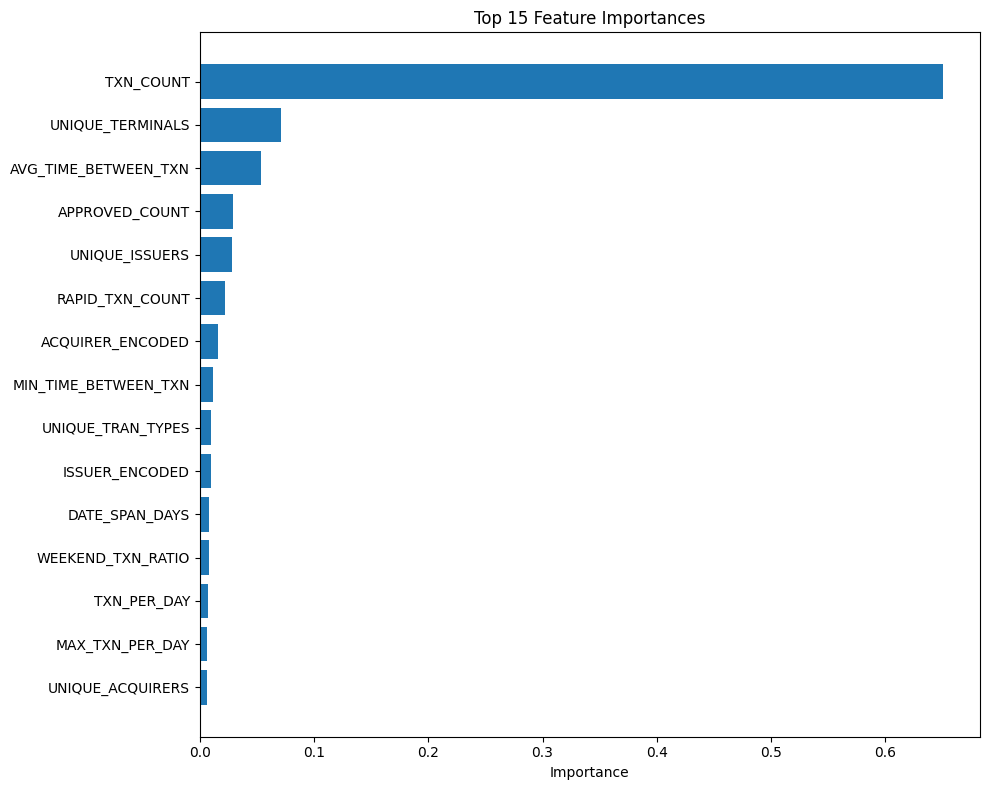

In [46]:
# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()

# 15. ML VS RULE-BASED COMPARISON

In [47]:
# Overlap analysis
both_flagged = (xgb_pred == 1) & (y_test == 1)
only_ml = (xgb_pred == 1) & (y_test == 0)
only_rules = (xgb_pred == 0) & (y_test == 1)

In [48]:
print(f"Flagged by BOTH ML and rules:  {both_flagged.sum():,}")
print(f"Flagged by ML ONLY:            {only_ml.sum():,}  ← NEW discoveries")
print(f"Flagged by RULES ONLY:         {only_rules.sum():,}  ← ML missed these")

Flagged by BOTH ML and rules:  34,649
Flagged by ML ONLY:            26,434  ← NEW discoveries
Flagged by RULES ONLY:         5,284  ← ML missed these


In [49]:
if only_ml.sum() > 0:
    print(f"\n ML discovers {only_ml.sum():,} potentially anomalous PANs the rules didn't catch!")
    print(f"   This represents {only_ml.sum()/(both_flagged.sum() + only_ml.sum())*100:.1f}% of ML's flags")


 ML discovers 26,434 potentially anomalous PANs the rules didn't catch!
   This represents 43.3% of ML's flags


In [50]:
# Analyze the ML-only flags
ml_only_pans = X_test[only_ml].copy()
ml_only_pans['RISK_SCORE'] = xgb_proba[only_ml]

# Compare characteristics
print("=== ML-ONLY FLAGS vs RULE-FLAGGED PANS ===")

# ML-only stats
print("\nML-Only PANs (not in fraud table):")
print(ml_only_pans[['TXN_COUNT', 'TOTAL_AMOUNT', 'MAX_TXN_PER_DAY', 
                    'NIGHT_TXN_COUNT', 'UNIQUE_TERMINALS']].describe())

# Rule-flagged stats (both caught)
both_pans = X_test[both_flagged].copy()
print("\nRule-Flagged PANs (in fraud table):")
print(both_pans[['TXN_COUNT', 'TOTAL_AMOUNT', 'MAX_TXN_PER_DAY',
                 'NIGHT_TXN_COUNT', 'UNIQUE_TERMINALS']].describe())

# Are they similar patterns?
print("\n=== Comparison ===")
print(f"ML-only avg TXN_COUNT: {ml_only_pans['TXN_COUNT'].mean():.1f}")
print(f"Rule-flagged avg TXN_COUNT: {both_pans['TXN_COUNT'].mean():.1f}")

print(f"\nML-only avg NIGHT_TXN_COUNT: {ml_only_pans['NIGHT_TXN_COUNT'].mean():.1f}")
print(f"Rule-flagged avg NIGHT_TXN_COUNT: {both_pans['NIGHT_TXN_COUNT'].mean():.1f}")

=== ML-ONLY FLAGS vs RULE-FLAGGED PANS ===

ML-Only PANs (not in fraud table):
          TXN_COUNT  TOTAL_AMOUNT  MAX_TXN_PER_DAY  NIGHT_TXN_COUNT  \
count  26434.000000  2.643400e+04     26434.000000     26434.000000   
mean       5.429220  4.030078e+08         2.878528         0.576076   
std      389.319886  2.153815e+10       135.875672        58.514465   
min        1.000000  0.000000e+00         1.000000         0.000000   
25%        1.000000  1.000000e+02         1.000000         0.000000   
50%        2.000000  3.000000e+07         2.000000         0.000000   
75%        2.000000  1.000000e+08         2.000000         0.000000   
max    48285.000000  3.412797e+12     20596.000000      8557.000000   

       UNIQUE_TERMINALS  
count      26434.000000  
mean           1.039873  
std            0.333615  
min            1.000000  
25%            1.000000  
50%            1.000000  
75%            1.000000  
max           38.000000  

Rule-Flagged PANs (in fraud table):
          

## 15.1 Analyze ML-only flags

In [51]:
if only_ml.sum() > 0:
    print(f"\n--- Sample PANs Flagged by ML but Not Rules ---")
    ml_only_df = X_test[only_ml].copy()
    ml_only_df['ML_RISK_SCORE'] = xgb_proba[only_ml]
    
    # Show top 5 by risk score
    top_ml_only = ml_only_df.nlargest(5, 'ML_RISK_SCORE')
    
    display_cols = ['TXN_COUNT', 'TOTAL_AMOUNT', 'MAX_TXN_PER_DAY', 'NIGHT_TXN_COUNT', 
                   'RAPID_TXN_COUNT', 'ML_RISK_SCORE']
    display_cols = [col for col in display_cols if col in top_ml_only.columns]
    
    print(top_ml_only[display_cols].to_string())


--- Sample PANs Flagged by ML but Not Rules ---
         TXN_COUNT  TOTAL_AMOUNT  MAX_TXN_PER_DAY  NIGHT_TXN_COUNT  RAPID_TXN_COUNT  ML_RISK_SCORE
1439598         33   237500000.0                8                0               25       0.994661
395682           4   415000096.0                2                0                2       0.994655
643382           7   460000000.0                7                0                5       0.994622
783274           8   126000000.0                8                0                4       0.994599
1231383         10   148000000.0               10                2                6       0.994592


## 15.2 Analyze rules-only flags (what ML missed)

In [52]:
if only_rules.sum() > 0:
    print(f"\n--- Sample PANs Flagged by Rules but Missed by ML ---")
    rules_only_df = X_test[only_rules].copy()
    rules_only_df['ML_RISK_SCORE'] = xgb_proba[only_rules]
    
    # Show bottom 5 by risk score (lowest confidence)
    bottom_rules = rules_only_df.nsmallest(5, 'ML_RISK_SCORE')
    
    display_cols = ['TXN_COUNT', 'TOTAL_AMOUNT', 'MAX_TXN_PER_DAY', 'NIGHT_TXN_COUNT',
                   'RAPID_TXN_COUNT', 'ML_RISK_SCORE']
    display_cols = [col for col in display_cols if col in bottom_rules.columns]
    
    print(bottom_rules[display_cols].to_string())


--- Sample PANs Flagged by Rules but Missed by ML ---
         TXN_COUNT  TOTAL_AMOUNT  MAX_TXN_PER_DAY  NIGHT_TXN_COUNT  RAPID_TXN_COUNT  ML_RISK_SCORE
824505           1     1000000.0                1                1                0       0.003888
2310194          1     4600000.0                1                0                0       0.004410
2329808          2     4800000.0                2                1                0       0.005039
2552418          1     2300000.0                1                1                0       0.005464
1940117          1     2000000.0                1                0                0       0.005881


# 16. THRESHOLD ANALYSIS

In [53]:
print("\nML Risk Score Distribution:")
print(f"  Min:  {xgb_proba.min():.3f}")
print(f"  25%:  {np.percentile(xgb_proba, 25):.3f}")
print(f"  50%:  {np.percentile(xgb_proba, 50):.3f}")
print(f"  75%:  {np.percentile(xgb_proba, 75):.3f}")
print(f"  90%:  {np.percentile(xgb_proba, 90):.3f}")
print(f"  95%:  {np.percentile(xgb_proba, 95):.3f}")
print(f"  Max:  {xgb_proba.max():.3f}")


ML Risk Score Distribution:
  Min:  0.003
  25%:  0.008
  50%:  0.039
  75%:  0.199
  90%:  0.450
  95%:  0.877
  Max:  0.997


In [54]:
# Test different thresholds
thresholds = [0.3, 0.5, 0.7, 0.9]

for threshold in thresholds:
    pred_at_threshold = (xgb_proba >= threshold).astype(int)
    tn_t, fp_t, fn_t, tp_t = confusion_matrix(y_test, pred_at_threshold).ravel()
    
    precision_t = tp_t / (tp_t + fp_t) if (tp_t + fp_t) > 0 else 0
    recall_t = tp_t / (tp_t + fn_t) if (tp_t + fn_t) > 0 else 0
    
    print(f"\nThreshold: {threshold:.1f}")
    print(f"  Flagged PANs: {(pred_at_threshold == 1).sum():,}")
    print(f"  Precision: {precision_t:.3f}")
    print(f"  Recall:    {recall_t:.3f}")


Threshold: 0.3
  Flagged PANs: 114,210
  Precision: 0.324
  Recall:    0.928

Threshold: 0.5
  Flagged PANs: 61,083
  Precision: 0.567
  Recall:    0.868

Threshold: 0.7
  Flagged PANs: 45,522
  Precision: 0.724
  Recall:    0.825

Threshold: 0.9
  Flagged PANs: 34,085
  Precision: 0.876
  Recall:    0.748


# 17. MODEL TRAINING WITH TOP 15 FEATURES

In [55]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 features:")
print(feature_importance.head(15))

# Train model with only top features
top_features = feature_importance.head(15)['feature'].tolist

Top 15 features:
                 feature  importance
0              TXN_COUNT    0.650359
16      UNIQUE_TERMINALS    0.070854
17  AVG_TIME_BETWEEN_TXN    0.053305
10        APPROVED_COUNT    0.029270
28        UNIQUE_ISSUERS    0.028259
19       RAPID_TXN_COUNT    0.022423
31      ACQUIRER_ENCODED    0.015577
18  MIN_TIME_BETWEEN_TXN    0.011895
15     UNIQUE_TRAN_TYPES    0.010035
30        ISSUER_ENCODED    0.009651
6         DATE_SPAN_DAYS    0.008535
23     WEEKEND_TXN_RATIO    0.007968
27           TXN_PER_DAY    0.007366
20       MAX_TXN_PER_DAY    0.006779
29      UNIQUE_ACQUIRERS    0.006633


In [56]:
top_15_features = [
    'TXN_COUNT',
    'UNIQUE_TERMINALS',
    'UNIQUE_ISSUERS',
    'MIN_TIME_BETWEEN_TXN',
    'ACQUIRER_ENCODED',
    'APPROVED_COUNT',
    'ISSUER_ENCODED',
    'RAPID_TXN_COUNT',
    'UNIQUE_TRAN_TYPES',
    'AVG_TIME_BETWEEN_TXN',
    'WEEKEND_TXN_COUNT',
    'TOTAL_AMOUNT',
    'MAX_TXN_PER_DAY',
    'MAX_AMOUNT_PER_DAY',
    'MIN_AMOUNT'
]

In [57]:
X_train_reduced = X_train[top_15_features]
X_test_reduced = X_test[top_15_features]

# Retrain
xgb_reduced = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

In [58]:
xgb_reduced.fit(X_train_reduced, y_train)
pred_reduced = xgb_reduced.predict(X_test_reduced)

In [59]:
# Check if performance is similar
print("\n=== REDUCED MODEL (15 features) ===")
print(classification_report(y_test, pred_reduced))


=== REDUCED MODEL (15 features) ===
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    671830
           1       0.54      0.87      0.67     39933

    accuracy                           0.95    711763
   macro avg       0.77      0.91      0.82    711763
weighted avg       0.97      0.95      0.96    711763



# 18. TRAIN AND COMPARE MODELS WITH TOP 10 FEATURES

In [60]:
# --- Get Top 10 Most Important Features ---
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Top 10 Most Important Features ---")
print(feature_importance.head(10).to_string(index=False))

# Create a list of top 10 features
top_10_features = feature_importance.head(10)['feature'].tolist()


--- Top 10 Most Important Features ---
             feature  importance
           TXN_COUNT    0.650359
    UNIQUE_TERMINALS    0.070854
AVG_TIME_BETWEEN_TXN    0.053305
      APPROVED_COUNT    0.029270
      UNIQUE_ISSUERS    0.028259
     RAPID_TXN_COUNT    0.022423
    ACQUIRER_ENCODED    0.015577
MIN_TIME_BETWEEN_TXN    0.011895
   UNIQUE_TRAN_TYPES    0.010035
      ISSUER_ENCODED    0.009651


In [61]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

In [62]:
# Use top 10 features
X_train_top10 = X_train[top_10_features]
X_test_top10 = X_test[top_10_features]

In [63]:
X_test_top10.head(5)

,TXN_COUNT,UNIQUE_TERMINALS,AVG_TIME_BETWEEN_TXN,APPROVED_COUNT,UNIQUE_ISSUERS,RAPID_TXN_COUNT,ACQUIRER_ENCODED,MIN_TIME_BETWEEN_TXN,UNIQUE_TRAN_TYPES,ISSUER_ENCODED
497607,1,1,0.000000,1,1,0,19,0.000000,1,19
2482315,1,1,0.000000,1,1,0,45,0.000000,1,15
1050048,1,1,0.000000,1,1,0,16,0.000000,1,34
2881453,2,2,0.137222,2,1,1,12,0.137222,1,12
3539506,2,1,386.087222,2,1,0,2,386.087222,1,4


497607     0
2482315    0
1050048    0
2881453    0
3539506    0
Name: LABEL, dtype: int64

In [64]:
print("\n--- XGBoost ---")
xgb_model_10 = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

xgb_model_10.fit(X_train_top10, y_train)
xgb_10_pred = xgb_model_10.predict(X_test_top10)


--- XGBoost ---


In [65]:
print(classification_report(y_test, xgb_10_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97    671830
           1       0.55      0.85      0.67     39933

    accuracy                           0.95    711763
   macro avg       0.77      0.91      0.82    711763
weighted avg       0.97      0.95      0.96    711763



In [66]:
print("\n--- Random Forest ---")
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_top10, y_train)
rf_pred = rf_model.predict(X_test_top10)
rf_prob = rf_model.predict_proba(X_test_top10)[:, 1]


--- Random Forest ---


In [67]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    671830
           1       0.89      0.69      0.78     39933

    accuracy                           0.98    711763
   macro avg       0.93      0.84      0.88    711763
weighted avg       0.98      0.98      0.98    711763



In [68]:
print("\n--- CatBoost ---")
cat_model = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    random_state=42,
    verbose=False
)
cat_model.fit(X_train_top10, y_train)
cat_pred = cat_model.predict(X_test_top10)
cat_prob = cat_model.predict_proba(X_test_top10)[:, 1]


--- CatBoost ---


In [69]:
print(classification_report(y_test, cat_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    671830
           1       0.91      0.68      0.78     39933

    accuracy                           0.98    711763
   macro avg       0.94      0.84      0.88    711763
weighted avg       0.98      0.98      0.98    711763



In [70]:
print("\n--- LightGBM ---")
lgbm_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
lgbm_model.fit(X_train_top10, y_train)
lgbm_pred = lgbm_model.predict(X_test_top10)
lgbm_prob = lgbm_model.predict_proba(X_test_top10)[:, 1]


--- LightGBM ---
[LightGBM] [Info] Number of positive: 159730, number of negative: 2687319
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 2847049, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.056104 -> initscore=-2.822814
[LightGBM] [Info] Start training from score -2.822814


In [71]:
print(classification_report(y_test, lgbm_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    671830
           1       0.91      0.69      0.78     39933

    accuracy                           0.98    711763
   macro avg       0.95      0.84      0.89    711763
weighted avg       0.98      0.98      0.98    711763



# 19. EXPORTING FINAL BEST MODEL

In [72]:
import os
import joblib

In [73]:
# Create folder for models
os.makedirs("models", exist_ok=True)

# Save LightGBM and XGBoost models
joblib.dump(lgbm_model, "models/lightgbm_model.pkl")
joblib.dump(xgb_model_10, "models/xgboost_stage2_model.pkl")

print("Models saved to /models directory")

Models saved to /models directory
